In [1]:
from tqdm import tqdm
from monai.networks.nets import UNet
from ply_creation_lib import create_ply
from skimage.measure import block_reduce
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import monai.losses as losses
import torch.optim as optim
import pydicom as dicom
import torchio as tio
import numpy as np
import pickle
import torch
import time
import copy
import json
import os

In [ ]:
def get_annotated_data() -> list[dict[str, np.ndarray]]:
    data = []
    for annotation_file in tqdm(os.listdir('annotations'), desc='scanning files'):
        mask = read_annotation(f'annotations\\{annotation_file}')
        scan_folder = '_'.join(annotation_file.split('_')[:2])
        scan = read_dicom(scan_folder)

        mask_limit = min(512, mask.shape[0])
        normal_size_mask = np.zeros((512, 512, 512), dtype=mask.dtype)
        normal_size_mask[:mask_limit, :, :] = mask[:mask_limit, :, :]

        normal_size_scan = np.zeros((512, 512, 512), dtype=scan.dtype)
        normal_size_scan[:mask_limit, :, :] = scan[:mask_limit, :, :]

        data.append({'scan': normal_size_scan, 'mask': normal_size_mask})
    return data

def read_dicom(input_folder: str) -> np.ndarray:
    files: list[str] = os.listdir(input_folder)
    data = [dicom.dcmread(f'{input_folder}\\{file}') for file in files if file.endswith('.dcm')]
    image = np.array([dicom.pixel_array(datum) for datum in data])
    image[image < 0] = 0
    return image

def downscale_data(data: list[dict[str, np.ndarray]], new_size: int) -> list[dict[str, np.ndarray]]:
    b_size = data[0]['mask'].shape[0] // new_size
    block_size = (b_size, b_size, b_size)

    new_data = []
    for datum in tqdm(data, desc='downscaling data'):
        downscaled_mask = downscale(datum['mask'], block_size) > 0.5
        downscaled_scan = downscale(datum['scan'], block_size)

        new_data.append({'scan': downscaled_scan, 'mask': downscaled_mask})
    return new_data

def downscale(input: np.ndarray, block_size: tuple) -> np.ndarray:
    return block_reduce(input, block_size=block_size, func=np.mean)

def save_new_data(data: list[dict[str, np.ndarray]]) -> None:
    for i, datum in enumerate(tqdm(data, desc='saving data')):
        np.save(f'd:\\dicom\\my_dataset\\base\\scans\\{i}.npy', datum['scan'])
        np.save(f'd:\\dicom\\my_dataset\\base\\masks\\{i}.npy', datum['mask'])

def save_augmented_data(data: list[tuple], folder: str = 'augmented') -> None:
    for i, datum in enumerate(tqdm(data, desc='saving data')):
        np.save(f'd:\\dicom\\my_dataset\\{folder}\\scans\\{i}.npy', datum[0])
        np.save(f'd:\\dicom\\my_dataset\\{folder}\\masks\\{i}.npy', datum[1].astype(bool))

def save_augmented_datum(data: tuple, i: int, folder: str = 'augmented') -> None:
    np.save(f'd:\\dicom\\my_dataset\\{folder}\\scans\\{i}.npy', data[0])
    np.save(f'd:\\dicom\\my_dataset\\{folder}\\masks\\{i}.npy', data[1].astype(bool))

def get_transformation():
    return tio.Compose([
        tio.RandomFlip(axes=(1, 2), p=0.5),
        tio.RandomAffine(
            degrees=(0, 0, 360),
            scales=(0.9, 1.1),
            translation=(5, 5, 5),
            p=0.5),
        tio.RandomElasticDeformation(num_control_points=7, max_displacement=5, p=0.5),
        tio.RandomGamma(p=0.5),
        tio.RandomNoise(mean=0, std=0.1, p=0.5),
        tio.RandomBiasField(p=0.5)])

def rotation_transformation():
    return tio.Compose([
        tio.RandomAffine(
            degrees=(0, 0, 360),
            scales=(0.9, 1.1),
            translation=(5, 5, 5),
            p=0.5),
        tio.RandomFlip(axes=(1, 2), p=0.5)])

def get_subject(scan: np.ndarray, mask: np.ndarray) -> tio.Subject:
    return tio.Subject(
        scan=tio.ScalarImage(tensor=np.expand_dims(scan, axis=0)),
        mask=tio.LabelMap(tensor=np.expand_dims(mask, axis=0)))

def augment(scan: np.ndarray, mask: np.ndarray, transform: tio.Compose) -> tuple[np.ndarray, np.ndarray]:
    subject = get_subject(scan, mask)
    augmented_subject = transform(subject)
    aug_scan: np.ndarray = augmented_subject['scan'].numpy()[0]
    aug_mask: np.ndarray = augmented_subject['mask'].numpy()[0]
    return (aug_scan, aug_mask)

def data_augmentation(downscaled_data: list[dict[str, np.ndarray]], augment_count: int, nii: bool):
    transform = rotation_transformation() if nii else get_transformation()

    augmented_data = []
    for i, datum in enumerate(downscaled_data):
        if nii:
            scan, mask = datum
        else:
            scan = datum['scan']
            mask = datum['mask']

        for _ in tqdm(range(augment_count), desc=f'augmenting data {i+1}/{len(downscaled_data)}'):
            aug_scan, aug_mask = augment(scan, mask, transform)
            aug_scan = aug_scan.astype(np.int16)
            aug_mask = aug_mask.astype(bool)
            augmented_data.append((aug_scan, aug_mask))
    return augmented_data

def get_prepared_data(folder: str) -> list[dict[str, np.ndarray]]:
    filenames = os.listdir(f'd:\\dicom\\my_dataset\\{folder}\\scans')
    filenames.sort(key = lambda x: int(x.split('.')[0]))

    data = []
    for filename in tqdm(filenames, desc='loading data'):
        scan = np.load(f'd:\\dicom\\my_dataset\\{folder}\\scans\\{filename}').astype(np.int16)
        mask = np.load(f'd:\\dicom\\my_dataset\\{folder}\\masks\\{filename}').astype(np.int16)
        data.append((scan, mask))
    return data

def read_annotation(annotation_file: str) -> np.ndarray:
    return np.load(annotation_file)

def get_data(from_annotations: bool, new_data_size: int, augment_count: int, folder: str = 'nii_augmented'):
    if from_annotations:
        data = get_annotated_data()

        data = downscale_data(data, new_data_size)
        save_new_data(data)
        augmented_data = data_augmentation(data, augment_count, nii=False)
        save_augmented_data(augmented_data)
        return augmented_data
    
    return get_prepared_data(folder)

In [25]:
train_size = 0.8
test_size = 0.5
new_data_size = 128
augment_count = 4
from_annotations = True

model_output_folder = f'{os.getcwd()}\\models'

In [ ]:
get_data()

In [ ]:
downscaled_data = get_data(from_annotations, new_data_size, augment_count)

In [16]:
class DataLoaderDataset(Dataset):
    def __init__(self, data_folder: str, filenames: list):
        self.data_folder = data_folder
        self.filenames = filenames

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        filename = self.filenames[idx]
        scan = np.load(f'{self.data_folder}\\scans\\{filename}')
        mask = np.load(f'{self.data_folder}\\masks\\{filename}')
        scan = torch.tensor(scan, dtype=torch.float32).unsqueeze(0)
        mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)
        return (scan, mask)

selected_data_folder = 'nii_augmented'
location_folder = f'D:\\dicom\\my_dataset\\{selected_data_folder}'
filenames = os.listdir(f'{location_folder}\\scans')

validation_filenames, training_filenames = train_test_split(filenames, test_size=int(len(filenames)*train_size), random_state=11)
validation_filenames, testing_filenames = train_test_split(validation_filenames, test_size=int(len(validation_filenames)*test_size), random_state=11)


train_dataset = DataLoaderDataset(location_folder, training_filenames)
val_dataset = DataLoaderDataset(location_folder, validation_filenames)
test_dataset = DataLoaderDataset(location_folder, testing_filenames)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=True, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=True, num_workers=0, pin_memory=True)

print(len(train_dataset))

3200


In [15]:
class TrainingDataset(Dataset):
    def __init__(self, data_list):
        self.data_list = data_list

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        scan, mask = self.data_list[idx]
        scan = torch.tensor(scan, dtype=torch.float32).unsqueeze(0)
        mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)
        return scan, mask

validation_filenames, training_data = train_test_split(downscaled_data, test_size=int(len(downscaled_data)*train_size), random_state=11)
validation_filenames, testing_data = train_test_split(validation_filenames, test_size=int(len(validation_filenames)*test_size), random_state=11)

train_dataset = TrainingDataset(training_data)
val_dataset = TrainingDataset(validation_filenames)
test_dataset = TrainingDataset(testing_data)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=True, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=True, num_workers=0, pin_memory=True)

NameError: name 'downscaled_data' is not defined

In [17]:
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=1,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=1
).to('cuda')

criterion = losses.DiceLoss(sigmoid=True)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [18]:
def dice_coefficient(pred, target):
    smooth = 1e-6
    intersection = (pred * target).sum()
    return (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

num_epochs = 100


metrics = {'train_loss': [], 'train_dice': [], 'val_loss': [], 'val_dice': []}
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    epoch_dice = 0.0

    for scans, masks in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
        scans, masks = scans.to('cuda'), masks.to('cuda')

        optimizer.zero_grad()
        outputs = model(scans)

        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        outputs_bin = torch.sigmoid(outputs) > 0.5
        dice = dice_coefficient(outputs_bin, masks)

        epoch_loss += loss.item()
        epoch_dice += dice.item()

    epoch_loss /= len(train_loader)
    epoch_dice /= len(train_loader)

    train_results = f'training - loss: {epoch_loss:.4f}, dice: {epoch_dice:.4f}'

    metrics['train_loss'].append(epoch_loss)
    metrics['train_dice'].append(epoch_dice)



    model.eval()
    val_loss = 0.0
    val_dice = 0.0

    with tqdm(val_loader, desc='Validating', leave=False) as vbar:
        with torch.no_grad():
            for test_scans, test_masks in vbar:
                test_scans, test_masks = test_scans.to('cuda'), test_masks.to('cuda')
                test_outputs = model(test_scans)
                val_loss += criterion(test_outputs, test_masks).item()
                val_dice += dice_coefficient(test_outputs, test_masks).item()

    val_loss /= len(val_loader)
    val_dice /= len(val_loader)

    val_results = f'validation - loss: {val_loss:.4f}, dice: {val_dice:.4f}'

    metrics['val_loss'].append(val_loss)
    metrics['val_dice'].append(val_dice)

    print(f'{train_results} | {val_results}', end='')
    # print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Dice Coeff: {epoch_dice:.4f}')

Epoch 1/100: 100%|██████████| 1600/1600 [08:30<00:00,  3.14it/s]


training - loss: 0.9974, dice: 0.0046 | validation - loss: 0.9965, dice: 0.0639

Epoch 2/100: 100%|██████████| 1600/1600 [07:25<00:00,  3.59it/s]


training - loss: 0.9938, dice: 0.0103 | validation - loss: 0.9907, dice: 0.1528

Epoch 3/100: 100%|██████████| 1600/1600 [07:24<00:00,  3.60it/s]


training - loss: 0.9878, dice: 0.0160 | validation - loss: 0.9838, dice: -0.1727

Epoch 4/100: 100%|██████████| 1600/1600 [07:24<00:00,  3.60it/s]


training - loss: 0.9794, dice: 0.0262 | validation - loss: 0.9742, dice: -0.1082

Epoch 5/100: 100%|██████████| 1600/1600 [07:25<00:00,  3.59it/s]


training - loss: 0.9668, dice: 0.0422 | validation - loss: 0.9561, dice: -0.0489

Epoch 6/100: 100%|██████████| 1600/1600 [07:26<00:00,  3.59it/s]


training - loss: 0.8803, dice: 0.1941 | validation - loss: 0.6999, dice: -0.0002

Epoch 7/100: 100%|██████████| 1600/1600 [07:27<00:00,  3.57it/s]


training - loss: 0.5903, dice: 0.4859 | validation - loss: 0.5366, dice: 0.0001

Epoch 8/100: 100%|██████████| 1600/1600 [07:25<00:00,  3.59it/s]


training - loss: 0.4974, dice: 0.5341 | validation - loss: 0.4919, dice: -0.0002

Epoch 9/100: 100%|██████████| 1600/1600 [07:25<00:00,  3.59it/s]


training - loss: 0.4596, dice: 0.5586 | validation - loss: 0.4752, dice: -0.0001

Epoch 10/100: 100%|██████████| 1600/1600 [07:26<00:00,  3.58it/s]


training - loss: 0.4365, dice: 0.5764 | validation - loss: 0.4592, dice: -0.0003

Epoch 11/100: 100%|██████████| 1600/1600 [07:25<00:00,  3.59it/s]


training - loss: 0.4187, dice: 0.5907 | validation - loss: 0.4535, dice: -0.0002

Epoch 12/100: 100%|██████████| 1600/1600 [07:25<00:00,  3.59it/s]


training - loss: 0.4042, dice: 0.6038 | validation - loss: 0.4415, dice: -0.0003

Epoch 13/100: 100%|██████████| 1600/1600 [07:18<00:00,  3.65it/s]


training - loss: 0.3921, dice: 0.6150 | validation - loss: 0.4359, dice: -0.0002

Epoch 14/100: 100%|██████████| 1600/1600 [06:58<00:00,  3.82it/s]


training - loss: 0.3807, dice: 0.6256 | validation - loss: 0.4462, dice: 0.0000

Epoch 15/100: 100%|██████████| 1600/1600 [06:57<00:00,  3.83it/s]


training - loss: 0.3720, dice: 0.6341 | validation - loss: 0.4240, dice: -0.0003

Epoch 16/100: 100%|██████████| 1600/1600 [06:57<00:00,  3.83it/s]


training - loss: 0.3635, dice: 0.6416 | validation - loss: 0.4300, dice: -0.0001

Epoch 17/100: 100%|██████████| 1600/1600 [06:56<00:00,  3.84it/s]


training - loss: 0.3568, dice: 0.6488 | validation - loss: 0.4211, dice: -0.0002

Epoch 18/100: 100%|██████████| 1600/1600 [06:58<00:00,  3.82it/s]


training - loss: 0.3494, dice: 0.6552 | validation - loss: 0.4132, dice: -0.0003

Epoch 19/100: 100%|██████████| 1600/1600 [06:58<00:00,  3.82it/s]


training - loss: 0.3433, dice: 0.6615 | validation - loss: 0.4116, dice: -0.0002

Epoch 20/100: 100%|██████████| 1600/1600 [06:58<00:00,  3.82it/s]


training - loss: 0.3375, dice: 0.6670 | validation - loss: 0.4113, dice: -0.0002

Epoch 21/100: 100%|██████████| 1600/1600 [06:56<00:00,  3.84it/s]


training - loss: 0.3342, dice: 0.6702 | validation - loss: 0.4147, dice: -0.0001

Epoch 22/100: 100%|██████████| 1600/1600 [06:56<00:00,  3.84it/s]


training - loss: 0.3275, dice: 0.6764 | validation - loss: 0.4209, dice: -0.0001

Epoch 23/100: 100%|██████████| 1600/1600 [06:57<00:00,  3.84it/s]


training - loss: 0.3236, dice: 0.6802 | validation - loss: 0.4091, dice: -0.0002

Epoch 24/100: 100%|██████████| 1600/1600 [06:58<00:00,  3.83it/s]


training - loss: 0.3198, dice: 0.6839 | validation - loss: 0.4066, dice: -0.0002

Epoch 25/100: 100%|██████████| 1600/1600 [06:56<00:00,  3.84it/s]


training - loss: 0.3156, dice: 0.6878 | validation - loss: 0.4028, dice: -0.0003

Epoch 26/100: 100%|██████████| 1600/1600 [06:56<00:00,  3.84it/s]


training - loss: 0.3124, dice: 0.6908 | validation - loss: 0.4066, dice: -0.0002

Epoch 27/100: 100%|██████████| 1600/1600 [06:56<00:00,  3.84it/s]


training - loss: 0.3090, dice: 0.6944 | validation - loss: 0.3971, dice: -0.0002

Epoch 28/100: 100%|██████████| 1600/1600 [06:56<00:00,  3.84it/s]


training - loss: 0.3083, dice: 0.6949 | validation - loss: 0.3980, dice: -0.0003

Epoch 29/100: 100%|██████████| 1600/1600 [06:56<00:00,  3.84it/s]


training - loss: 0.3024, dice: 0.7006 | validation - loss: 0.3972, dice: -0.0003

Epoch 30/100: 100%|██████████| 1600/1600 [06:57<00:00,  3.83it/s]


training - loss: 0.3000, dice: 0.7030 | validation - loss: 0.4005, dice: -0.0001

Epoch 31/100: 100%|██████████| 1600/1600 [06:56<00:00,  3.84it/s]


training - loss: 0.2976, dice: 0.7055 | validation - loss: 0.3941, dice: -0.0003

Epoch 32/100: 100%|██████████| 1600/1600 [06:57<00:00,  3.84it/s]


training - loss: 0.2948, dice: 0.7080 | validation - loss: 0.4028, dice: -0.0001

Epoch 33/100: 100%|██████████| 1600/1600 [06:57<00:00,  3.83it/s]


training - loss: 0.2927, dice: 0.7100 | validation - loss: 0.4017, dice: -0.0001

Epoch 34/100: 100%|██████████| 1600/1600 [06:57<00:00,  3.83it/s]


training - loss: 0.2918, dice: 0.7109 | validation - loss: 0.3980, dice: -0.0001

Epoch 35/100: 100%|██████████| 1600/1600 [06:57<00:00,  3.83it/s]


training - loss: 0.2875, dice: 0.7152 | validation - loss: 0.3956, dice: -0.0002

Epoch 36/100: 100%|██████████| 1600/1600 [06:57<00:00,  3.83it/s]


training - loss: 0.2860, dice: 0.7162 | validation - loss: 0.3997, dice: -0.0002

Epoch 37/100: 100%|██████████| 1600/1600 [06:57<00:00,  3.83it/s]


training - loss: 0.2840, dice: 0.7183 | validation - loss: 0.3959, dice: -0.0002

Epoch 38/100: 100%|██████████| 1600/1600 [06:57<00:00,  3.83it/s]


training - loss: 0.2823, dice: 0.7203 | validation - loss: 0.4089, dice: -0.0000

Epoch 39/100: 100%|██████████| 1600/1600 [06:57<00:00,  3.83it/s]


training - loss: 0.2804, dice: 0.7222 | validation - loss: 0.3931, dice: -0.0001

Epoch 40/100: 100%|██████████| 1600/1600 [06:58<00:00,  3.82it/s]


training - loss: 0.2781, dice: 0.7241 | validation - loss: 0.3889, dice: -0.0002

Epoch 41/100: 100%|██████████| 1600/1600 [06:58<00:00,  3.83it/s]


training - loss: 0.2761, dice: 0.7262 | validation - loss: 0.3936, dice: -0.0002

Epoch 42/100: 100%|██████████| 1600/1600 [06:57<00:00,  3.83it/s]


training - loss: 0.2749, dice: 0.7276 | validation - loss: 0.3883, dice: -0.0002

Epoch 43/100: 100%|██████████| 1600/1600 [06:57<00:00,  3.83it/s]


training - loss: 0.2735, dice: 0.7284 | validation - loss: 0.3929, dice: -0.0002

Epoch 44/100: 100%|██████████| 1600/1600 [06:57<00:00,  3.84it/s]


training - loss: 0.2719, dice: 0.7302 | validation - loss: 0.3947, dice: -0.0001

Epoch 45/100: 100%|██████████| 1600/1600 [06:57<00:00,  3.83it/s]


training - loss: 0.2702, dice: 0.7318 | validation - loss: 0.3902, dice: -0.0002

Epoch 46/100: 100%|██████████| 1600/1600 [06:56<00:00,  3.84it/s]


training - loss: 0.2687, dice: 0.7335 | validation - loss: 0.3890, dice: -0.0002

Epoch 47/100: 100%|██████████| 1600/1600 [06:57<00:00,  3.83it/s]


training - loss: 0.2676, dice: 0.7344 | validation - loss: 0.4012, dice: -0.0001

Epoch 48/100: 100%|██████████| 1600/1600 [06:56<00:00,  3.84it/s]


training - loss: 0.2662, dice: 0.7356 | validation - loss: 0.3921, dice: -0.0002

Epoch 49/100: 100%|██████████| 1600/1600 [06:56<00:00,  3.85it/s]


training - loss: 0.2647, dice: 0.7369 | validation - loss: 0.3892, dice: -0.0001

Epoch 50/100: 100%|██████████| 1600/1600 [06:57<00:00,  3.84it/s]


training - loss: 0.2630, dice: 0.7388 | validation - loss: 0.4007, dice: -0.0001

Epoch 51/100: 100%|██████████| 1600/1600 [06:56<00:00,  3.84it/s]


training - loss: 0.2621, dice: 0.7399 | validation - loss: 0.3963, dice: -0.0002

Epoch 52/100: 100%|██████████| 1600/1600 [06:56<00:00,  3.84it/s]


training - loss: 0.2609, dice: 0.7410 | validation - loss: 0.3855, dice: -0.0002

Epoch 53/100: 100%|██████████| 1600/1600 [06:57<00:00,  3.83it/s]


training - loss: 0.2596, dice: 0.7424 | validation - loss: 0.3904, dice: -0.0002

Epoch 54/100: 100%|██████████| 1600/1600 [06:57<00:00,  3.83it/s]


training - loss: 0.2583, dice: 0.7436 | validation - loss: 0.3932, dice: -0.0002

Epoch 55/100: 100%|██████████| 1600/1600 [06:57<00:00,  3.84it/s]


training - loss: 0.2571, dice: 0.7445 | validation - loss: 0.3934, dice: -0.0001

Epoch 56/100: 100%|██████████| 1600/1600 [06:56<00:00,  3.84it/s]


training - loss: 0.2560, dice: 0.7456 | validation - loss: 0.3855, dice: -0.0002

Epoch 57/100: 100%|██████████| 1600/1600 [06:56<00:00,  3.84it/s]


training - loss: 0.2551, dice: 0.7465 | validation - loss: 0.3932, dice: -0.0002

Epoch 58/100: 100%|██████████| 1600/1600 [06:56<00:00,  3.84it/s]


training - loss: 0.2540, dice: 0.7475 | validation - loss: 0.3928, dice: -0.0001

Epoch 59/100: 100%|██████████| 1600/1600 [06:56<00:00,  3.84it/s]


training - loss: 0.2529, dice: 0.7490 | validation - loss: 0.3851, dice: -0.0002

Epoch 60/100: 100%|██████████| 1600/1600 [06:56<00:00,  3.84it/s]


training - loss: 0.2520, dice: 0.7494 | validation - loss: 0.3846, dice: -0.0002

Epoch 61/100: 100%|██████████| 1600/1600 [06:57<00:00,  3.84it/s]


training - loss: 0.2503, dice: 0.7512 | validation - loss: 0.3905, dice: -0.0002

Epoch 62/100: 100%|██████████| 1600/1600 [06:57<00:00,  3.84it/s]


training - loss: 0.2498, dice: 0.7517 | validation - loss: 0.3929, dice: -0.0002

Epoch 63/100: 100%|██████████| 1600/1600 [06:57<00:00,  3.83it/s]


training - loss: 0.2489, dice: 0.7526 | validation - loss: 0.3908, dice: -0.0002

Epoch 64/100: 100%|██████████| 1600/1600 [06:57<00:00,  3.83it/s]


training - loss: 0.2476, dice: 0.7539 | validation - loss: 0.3841, dice: -0.0002

Epoch 65/100: 100%|██████████| 1600/1600 [06:57<00:00,  3.83it/s]


training - loss: 0.2470, dice: 0.7546 | validation - loss: 0.3844, dice: -0.0002

Epoch 66/100: 100%|██████████| 1600/1600 [06:57<00:00,  3.83it/s]


training - loss: 0.2460, dice: 0.7554 | validation - loss: 0.3947, dice: -0.0001

Epoch 67/100: 100%|██████████| 1600/1600 [06:56<00:00,  3.84it/s]


training - loss: 0.2452, dice: 0.7564 | validation - loss: 0.3891, dice: -0.0002

Epoch 68/100: 100%|██████████| 1600/1600 [06:57<00:00,  3.83it/s]


training - loss: 0.2442, dice: 0.7570 | validation - loss: 0.3911, dice: -0.0002

Epoch 69/100: 100%|██████████| 1600/1600 [06:57<00:00,  3.84it/s]


training - loss: 0.2436, dice: 0.7574 | validation - loss: 0.3885, dice: -0.0002

Epoch 70/100: 100%|██████████| 1600/1600 [06:58<00:00,  3.82it/s]


training - loss: 0.2424, dice: 0.7591 | validation - loss: 0.3851, dice: -0.0002

Epoch 71/100: 100%|██████████| 1600/1600 [06:57<00:00,  3.83it/s]


training - loss: 0.2418, dice: 0.7596 | validation - loss: 0.3925, dice: -0.0002

Epoch 72/100: 100%|██████████| 1600/1600 [06:58<00:00,  3.82it/s]


training - loss: 0.2408, dice: 0.7605 | validation - loss: 0.3896, dice: -0.0002

Epoch 73/100: 100%|██████████| 1600/1600 [06:58<00:00,  3.82it/s]


training - loss: 0.2402, dice: 0.7612 | validation - loss: 0.3853, dice: -0.0002

Epoch 74/100: 100%|██████████| 1600/1600 [06:57<00:00,  3.83it/s]


training - loss: 0.2394, dice: 0.7622 | validation - loss: 0.3902, dice: -0.0001

Epoch 75/100: 100%|██████████| 1600/1600 [06:57<00:00,  3.83it/s]


training - loss: 0.2383, dice: 0.7626 | validation - loss: 0.3953, dice: -0.0001

Epoch 76/100: 100%|██████████| 1600/1600 [06:57<00:00,  3.84it/s]


training - loss: 0.2374, dice: 0.7639 | validation - loss: 0.3880, dice: -0.0001

Epoch 77/100: 100%|██████████| 1600/1600 [06:57<00:00,  3.83it/s]


training - loss: 0.2364, dice: 0.7647 | validation - loss: 0.3893, dice: -0.0002

Epoch 78/100: 100%|██████████| 1600/1600 [06:56<00:00,  3.84it/s]


training - loss: 0.2360, dice: 0.7654 | validation - loss: 0.3861, dice: -0.0002

Epoch 79/100: 100%|██████████| 1600/1600 [06:57<00:00,  3.84it/s]


training - loss: 0.2352, dice: 0.7657 | validation - loss: 0.3874, dice: -0.0002

Epoch 80/100: 100%|██████████| 1600/1600 [06:58<00:00,  3.82it/s]


training - loss: 0.2353, dice: 0.7659 | validation - loss: 0.3866, dice: -0.0002

Epoch 81/100: 100%|██████████| 1600/1600 [06:58<00:00,  3.82it/s]


training - loss: 0.2336, dice: 0.7676 | validation - loss: 0.3894, dice: -0.0001

Epoch 82/100: 100%|██████████| 1600/1600 [06:56<00:00,  3.84it/s]


training - loss: 0.2331, dice: 0.7684 | validation - loss: 0.3818, dice: -0.0002

Epoch 83/100: 100%|██████████| 1600/1600 [06:57<00:00,  3.83it/s]


training - loss: 0.2327, dice: 0.7687 | validation - loss: 0.3892, dice: -0.0001

Epoch 84/100: 100%|██████████| 1600/1600 [06:57<00:00,  3.83it/s]


training - loss: 0.2318, dice: 0.7692 | validation - loss: 0.3849, dice: -0.0002

Epoch 85/100: 100%|██████████| 1600/1600 [06:57<00:00,  3.83it/s]


training - loss: 0.2311, dice: 0.7701 | validation - loss: 0.3893, dice: -0.0001

Epoch 86/100: 100%|██████████| 1600/1600 [06:57<00:00,  3.84it/s]


training - loss: 0.2307, dice: 0.7700 | validation - loss: 0.3912, dice: -0.0001

Epoch 87/100: 100%|██████████| 1600/1600 [06:56<00:00,  3.84it/s]


training - loss: 0.2299, dice: 0.7713 | validation - loss: 0.3888, dice: -0.0001

Epoch 88/100: 100%|██████████| 1600/1600 [06:58<00:00,  3.83it/s]


training - loss: 0.2293, dice: 0.7719 | validation - loss: 0.3874, dice: -0.0001

Epoch 89/100: 100%|██████████| 1600/1600 [06:57<00:00,  3.83it/s]


training - loss: 0.2287, dice: 0.7723 | validation - loss: 0.3870, dice: -0.0002

Epoch 90/100: 100%|██████████| 1600/1600 [06:57<00:00,  3.83it/s]


training - loss: 0.2279, dice: 0.7729 | validation - loss: 0.3879, dice: -0.0002

Epoch 91/100: 100%|██████████| 1600/1600 [06:58<00:00,  3.82it/s]


training - loss: 0.2274, dice: 0.7738 | validation - loss: 0.3936, dice: -0.0002

Epoch 92/100: 100%|██████████| 1600/1600 [06:57<00:00,  3.83it/s]


training - loss: 0.2269, dice: 0.7742 | validation - loss: 0.3829, dice: -0.0002

Epoch 93/100: 100%|██████████| 1600/1600 [06:57<00:00,  3.83it/s]


training - loss: 0.2262, dice: 0.7747 | validation - loss: 0.3840, dice: -0.0002

Epoch 94/100: 100%|██████████| 1600/1600 [06:56<00:00,  3.84it/s]


training - loss: 0.2256, dice: 0.7755 | validation - loss: 0.3905, dice: -0.0001

Epoch 95/100: 100%|██████████| 1600/1600 [06:56<00:00,  3.84it/s]


training - loss: 0.2249, dice: 0.7761 | validation - loss: 0.3834, dice: -0.0002

Epoch 96/100: 100%|██████████| 1600/1600 [06:57<00:00,  3.83it/s]


training - loss: 0.2242, dice: 0.7768 | validation - loss: 0.3897, dice: -0.0002

Epoch 97/100: 100%|██████████| 1600/1600 [06:57<00:00,  3.83it/s]


training - loss: 0.2237, dice: 0.7771 | validation - loss: 0.3979, dice: -0.0001

Epoch 98/100: 100%|██████████| 1600/1600 [06:57<00:00,  3.83it/s]


training - loss: 0.2230, dice: 0.7779 | validation - loss: 0.3892, dice: -0.0002

Epoch 99/100: 100%|██████████| 1600/1600 [06:57<00:00,  3.83it/s]


training - loss: 0.2226, dice: 0.7784 | validation - loss: 0.3878, dice: -0.0002

Epoch 100/100: 100%|██████████| 1600/1600 [06:56<00:00,  3.84it/s]
                                                             

training - loss: 0.2220, dice: 0.7789 | validation - loss: 0.3891, dice: -0.0002

In [23]:
last_model_number = max(int(i[5:]) for i in os.listdir(model_output_folder))
selected_folder = f'{model_output_folder}\\train{last_model_number+1}'
os.mkdir(selected_folder)

torch.save(model.state_dict(), f'{selected_folder}\\model.pth')
with open(f'{selected_folder}\\metrics.json', 'w') as f:
    json.dump(metrics, f, indent=4)

print(f'saved as \"{selected_folder}\"')

saved as "c:\Users\mariu\OneDrive - Kaunas University of Technology\univeras\bakalauras\dicom\models\train12"


In [ ]:
print(f'{selected_folder}\\model.pth')
print(metrics)
model.load_state_dict(torch.load(f'{selected_folder}\\model.pth'))
with open(f'{selected_folder}\\metrics.json', 'r') as f:
    metrics = json.load(f)

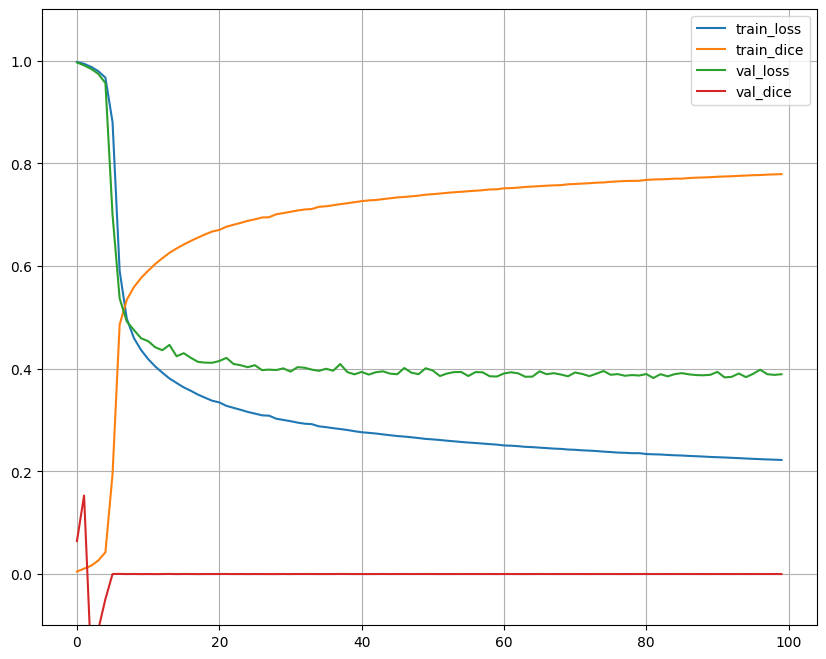

In [20]:
plt.figure(figsize=(10, 8))
for key in metrics:
    plt.plot(metrics[key])

plt.ylim([-0.1, 1.1])
plt.grid(which='both')
plt.legend(metrics.keys())
plt.show()

In [22]:
model.eval()
test_loss = 0.0
test_dice = 0.0

with tqdm(test_loader, desc='Testing', leave=False) as vbar:
    with torch.no_grad():
        for test_scans, test_masks in vbar:
            test_scans, test_masks = test_scans.to('cuda'), test_masks.to('cuda')
            test_outputs = model(test_scans)
            test_loss += criterion(test_outputs, test_masks).item()
            test_dice += dice_coefficient(test_outputs, test_masks).item()

print(f'loss: {test_loss/len(test_loader)}')
print(f'dice: {test_dice/len(test_loader)}')

loss: 0.3840697990357876
dice: -0.00021501523719393844
